In [1]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec

display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

## PID controller formulation

In the following example, we will examine the components and various definition methods of the Proportional-Integral-Derivating (PID) controller.
<br>As the name suggests, the system is composed of three distinct components (an integrator, a differentiator, and a gain), and the output is the weighted sum of these signals.

$$y_{PID}(t) = P\cdot u(t) + I\cdot\int u(t)dt + D\cdot\frac{d}{dt}u(t)$$

After Laplace transforming the model, the following transfer function can be assigned to the controller:

$$G_{PID}(s)=P+\frac{I}{s}+D\cdot s$$

<img src="Images/parpid.png" width="35%" />

This ideal form, where the components are separate and independent, is referred to as the ideal controller form. An alternate form of this controller can be formed by calculating the common gain of the three components (Kp). In this case, the remaining coefficients represent the frequency characteristics of the appropriate components. This form is usually referred to as the parallel form:

$$G_{PID} = K_p(1 + \frac{1}{T_is} + T_ds)$$

An alternate version of the controller is occasionally used, where the components are connected in series instead of parallel. In this case, the resulting equation is highly similar, but the gain for the P component is dependent on the time constants.

$$G_{PID} = K_p(1 + \frac{1}{T_is})(1 + T_ds) = K_p(1 + \frac{T_d}{T_i} + \frac{1}{T_is} + T_ds)$$

<img src="Images/serpid.png" width="60%" />

There is an issue with these PID models when it comes to analog electronic implementations. It is impossible to implement the ideal derivating component, as realistic components have a cutoff at high frequencies (infinite gain can not be implemented). This property can be modelled by including a first-order component in the transfer function. With this modification, the parallel model can be expressed as:

$$G_{PID} = K_p(1 + \frac{1}{T_is} + \frac{T_ds}{{T_d}'s + 1}) \qquad {T_d}'=\frac{T_d}{F_d} \qquad F_d \substack{\in\\ \sim} [8,\;20]$$

<br><b>Select a model type!</b>

In [2]:
# System type selector
typeSelect = w.ToggleButtons(
    options=[('Independent', 0), ('Parallel', 1), ('Serial', 2), ('Realistic', 3)],
    description='PID type: ', layout=w.Layout(width='100%'))

display(typeSelect)

ToggleButtons(description='PID type: ', layout=Layout(width='100%'), options=(('Independent', 0), ('Parallel',…

<b>Chose PID components! Observe the changes in the frequency characteristics!</b>

<IPython.core.display.Javascript object>


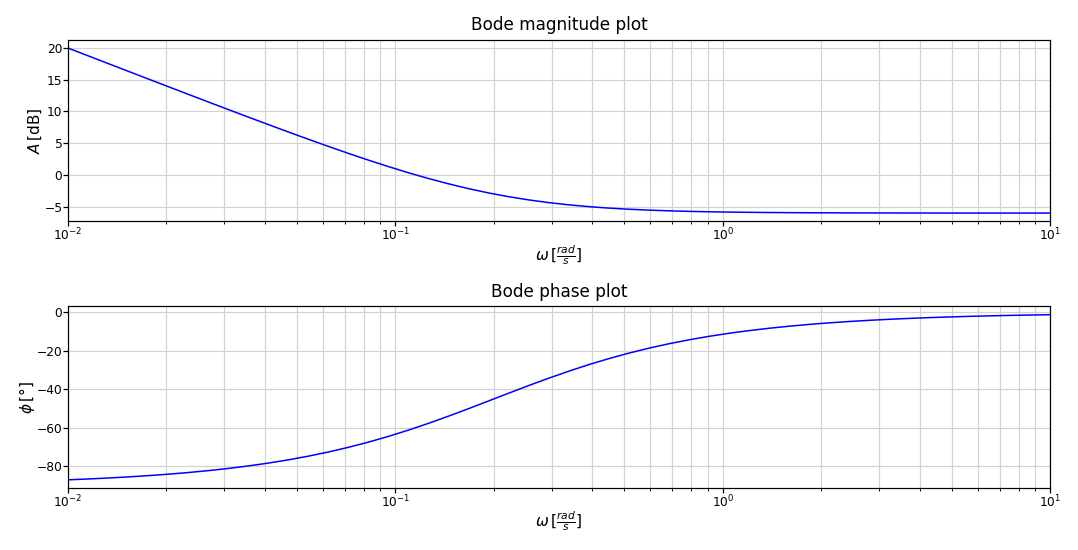

Output()

In [3]:
fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

f1_line1, = f1_ax1.plot([], [], lw=1, color='blue')
f1_line2, = f1_ax2.plot([], [], lw=1, color='blue')

f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='x', tight=True)
f1_ax2.autoscale(enable=True, axis='x', tight=True)
f1_ax1.autoscale(enable=True, axis='y', tight=False)
f1_ax2.autoscale(enable=True, axis='y', tight=False)

f1_ax1.set_title('Bode magnitude plot', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$\omega\/[\frac{rad}{s}]$', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Bode phase plot', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$\omega\/[\frac{rad}{s}]$', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)


def calculate_tf(P, I, D, I0, D0, model, F=1):   
    
    global I_slider, D_slider
    
    if I0:
        I_slider.disabled=False
    else:
        I_slider.disabled=True
        
    if D0:
        D_slider.disabled=False
    else:
        D_slider.disabled=True
    
    
    if model == 0: # Ideal
        
        W = c.parallel(c.tf([P], [1]),
                       c.tf([I * I0], [1 * I0, 1 * (not I0)]),
                       c.tf([D * D0, 0], [1]))
        
    elif model == 1: # Parallel
        
        W = c.parallel(c.tf([P], [1]),
                       c.tf([P / I * I0], [1 * I0, 1 * (not I0)]),
                       c.tf([P * D * D0, 0], [1]))
        
    elif model == 2: # Series
        
        W = c.parallel(c.tf([P + (D * D0 + 1 * (not D0)) / (I * I0 + 1 * (not I0))], [1]),
                       c.tf([P / I * I0], [1 * I0, 1 * (not I0)]),
                       c.tf([P * D * D0, 0], [1]))
        
    else: # Realistic
        
        W = c.parallel(c.tf([P], [1]),
                       c.tf([P / I * I0], [1 * I0, 1 * (not I0)]),
                       c.tf([P * D * D0, 0], [D / F * D0, 1]))
        
    print('PID transfer function:')
    print(W)
    
    global f1_line1, f1_line2
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax2.lines.remove(f1_line2)
    
    mag, phase, omega = c.bode_plot(W, Plot=False)   # Bode-plot 
    
    f1_line1, = f1_ax1.plot(omega, 20*np.log10(mag), lw=1, color='blue')
    f1_line2, = f1_ax2.plot(omega, phase*180/np.pi, lw=1, color='blue')
    
    f1_ax1.relim()
    f1_ax2.relim()
    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()        

def draw_controllers(model):
    
    global P_slider, I_slider, D_slider, I_button, D_button, F_slider
    
    if model == 0: # Ideal
        
        P_slider = w.FloatLogSlider(value=0.5, base=10, min=-4, max=4, description='$P$', continuous_update=False,
                                    layout=w.Layout(width='auto', flex='10 10 auto'))
        I_slider = w.FloatLogSlider(value=0.1, base=10, min=-4, max=4, description='$I$', continuous_update=False,
                                    layout=w.Layout(width='auto', flex='10 10 auto'))
        D_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=4, description='$D$', continuous_update=False,
                                    layout=w.Layout(width='auto', flex='10 10 auto'))

        I_button = w.ToggleButton(value=True, description='',
                                  layout=w.Layout(width='auto', flex='1 1 0%'))
        D_button = w.ToggleButton(value=False, description='',
                                  layout=w.Layout(width='auto', flex='1 1 0%'))

        input_data = w.interactive_output(calculate_tf, {'P': P_slider, 'I': I_slider, 'D': D_slider,
                                                         'I0' : I_button, 'D0': D_button,
                                                         'model': typeSelect})

        display(w.HBox([P_slider, I_button, I_slider, D_button, D_slider]), input_data)
        
    elif model in [1, 2]: # Series and Parallel
        
        P_slider = w.FloatLogSlider(value=0.5, base=10, min=-1, max=4, description='$K_p$', continuous_update=False,
                                    layout=w.Layout(width='auto', flex='10 10 auto'))
        I_slider = w.FloatLogSlider(value=0.0035, base=10, min=-4, max=1, description='$T_i$', continuous_update=False,
                                    layout=w.Layout(width='auto', flex='10 10 auto'))
        D_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=1, description='$T_d$', continuous_update=False,
                                    layout=w.Layout(width='auto', flex='10 10 auto'))

        I_button = w.ToggleButton(value=True, description='',
                                  layout=w.Layout(width='auto', flex='1 1 0%'))
        D_button = w.ToggleButton(value=False, description='',
                                  layout=w.Layout(width='auto', flex='1 1 0%'))

        input_data = w.interactive_output(calculate_tf, {'P': P_slider, 'I': I_slider, 'D': D_slider,
                                                         'I0' : I_button, 'D0': D_button,
                                                         'model': typeSelect})

        display(w.HBox([P_slider, I_button, I_slider, D_button, D_slider]), input_data)
        
    else: # Realistic
        
        P_slider = w.FloatLogSlider(value=0.5, base=10, min=-1, max=4, description='$K_p$', continuous_update=False,
                                    layout=w.Layout(width='auto', flex='10 10 auto'))
        I_slider = w.FloatLogSlider(value=0.0035, base=10, min=-4, max=1, description='$T_i$', continuous_update=False,
                                    layout=w.Layout(width='auto', flex='10 10 auto'))
        D_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=1, description='$T_d$', continuous_update=False,
                                    layout=w.Layout(width='auto', flex='10 10 auto'))
        F_slider = w.FloatLogSlider(value=1, base=10, min=0, max=3, description="${T_d}'=T_d/ $", continuous_update=False,
                                    layout=w.Layout(width='auto', flex='10 10 auto'))

        I_button = w.ToggleButton(value=True, description='',
                                  layout=w.Layout(width='auto', flex='1 1 0%'))
        D_button = w.ToggleButton(value=False, description='',
                                  layout=w.Layout(width='auto', flex='1 1 0%'))

        input_data = w.interactive_output(calculate_tf, {'P': P_slider, 'I': I_slider, 'D': D_slider,
                                                         'F': F_slider, 'I0' : I_button, 'D0': D_button,
                                                         'model': typeSelect})

        display(w.HBox([P_slider, I_button, I_slider, D_button, D_slider, F_slider]), input_data)
    
    
w.interactive_output(draw_controllers, {'model': typeSelect})